In [1]:
%matplotlib inline
import matplotlib as mpl;
import matplotlib.pyplot as plt;

import gzip
import pandas as pd

### Load one user's data:

In [2]:
import numpy as np;
import gzip;
import io as StringIO;

def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index('\n')]
    columns = headline.split(',')

    # The first column should be timestamp:
    assert columns[0] == 'timestamp'
    # The last column should be label_source:
    assert columns[-1] == 'label_source'
    
#     print('columns', columns, len(columns))
    
    # Search for the first column that starts with 'label:''
    for (ci,col) in enumerate(columns):
        if col.startswith('label:'):
            first_label_ind = ci
            break
        pass

    # The columns that we use as 'features' come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind]
    
    # The columns that we use as labels: 
    # From the first label" column' all the way to the penultimate column "label source"
    label_names = columns[first_label_ind:-1]
    
    # Remove the redundant prefix 'label:' for all the selected columns
    for (li, label) in enumerate(label_names):
        
        assert label.startswith('label:')
        label_names[li] = label.replace('label:','')
        pass
    
    return (feature_names,label_names)

def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO.StringIO(csv_str),delimiter=',',skiprows=1)
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int)
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)]
    
    # Read the binary label values, and the 'missing label' indicators:
    # This should have values of either 0., 1. or NaN
    trinary_labels_mat = full_table[:,(n_features+1):-1]
    
    # M is the missing label matrix
    M = np.isnan(trinary_labels_mat)
    
    # Y is the label matrix
    Y = np.where(M, 0, trinary_labels_mat) > 0.
    
    return (X,Y,M,timestamps)

'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''
def read_user_data(uuid):
    user_data_file = 'user_data/%s.features_labels.csv.gz' % uuid

    # Read the entire csv file of the user:
    with gzip.open(user_data_file,'rb') as fid:
        csv_str = fid.read().decode()
        pass

    feature_names, label_names = parse_header_of_csv(csv_str)
    n_features = len(feature_names)
    X, Y, M, timestamps  = parse_body_of_csv(csv_str,n_features)

    return (X,Y,M,timestamps,feature_names,label_names)

In [3]:
import os 
uuid_list = []

for file in os.listdir('user_data'):
    if file.split('.')[-1] == 'gz':
        uuid_list.append(file.split('.')[0])
print('We have %d users data in total.' %(len(uuid_list)) )

We have 60 users data in total.


In [4]:
uuid = uuid_list[0]
print('Load the first user: %s' %(uuid))
X,Y,M,timestamps,feature_names,label_names = read_user_data(uuid)
print('Number of instance: %d (~1 min per instance)' %X.shape[0])
print('Features: %d' %(X.shape[1]))
print('Labels: %d' %(Y.shape[1]))
print('Feature matrix X: (%d , %d)' % (X.shape[0], X.shape[1]))
print('Label matrix Y: (%d , %d)' % (Y.shape[0], Y.shape[1]))
print('Missing label matrix M: (%d , %d)' % (M.shape[0], M.shape[1]))

Load the first user: 00EABED2-271D-49D8-B599-1D4A09240601
Number of instance: 2287 (~1 min per instance)
Features: 225
Labels: 51
Feature matrix X: (2287 , 225)
Label matrix Y: (2287 , 51)
Missing label matrix M: (2287 , 51)


### The labels: 

In [5]:
n_examples_per_label = np.sum(Y, axis = 0)
labels_and_counts = zip(label_names,n_examples_per_label)

sorted_labels_and_counts = sorted(labels_and_counts,reverse=True,key=lambda pair:pair[1])
print("Total context labels the user has and the time spent on each of them:")
print("-"*20)
for (label,count) in sorted_labels_and_counts:
    print("label %s - %d minutes" % (label, count))
    pass

Total context labels the user has and the time spent on each of them:
--------------------
label PHONE_ON_TABLE - 1594 minutes
label OR_indoors - 1284 minutes
label SITTING - 1106 minutes
label LOC_home - 995 minutes
label LYING_DOWN - 657 minutes
label SLEEPING - 477 minutes
label WITH_CO-WORKERS - 331 minutes
label IN_A_MEETING - 306 minutes
label IN_CLASS - 214 minutes
label LOC_main_workplace - 197 minutes
label OR_standing - 193 minutes
label FIX_walking - 163 minutes
label COMPUTER_WORK - 89 minutes
label COOKING - 55 minutes
label EATING - 54 minutes
label ON_A_BUS - 49 minutes
label CLEANING - 38 minutes
label SHOPPING - 19 minutes
label DRESSING - 17 minutes
label BATHING_-_SHOWER - 15 minutes
label WATCHING_TV - 2 minutes
label FIX_running - 0 minutes
label BICYCLING - 0 minutes
label LAB_WORK - 0 minutes
label OR_outside - 0 minutes
label IN_A_CAR - 0 minutes
label DRIVE_-_I_M_THE_DRIVER - 0 minutes
label DRIVE_-_I_M_A_PASSENGER - 0 minutes
label FIX_restaurant - 0 minutes
l

In [6]:
# The labels are provided with standardized names
# we can prettify them in a very straightforward way

def get_label_pretty_name(label):
    if label == 'FIX_walking':
        return 'Walking';
    if label == 'FIX_running':
        return 'Running';
    if label == 'LOC_main_workplace':
        return 'At main workplace';
    if label == 'OR_indoors':
        return 'Indoors';
    if label == 'OR_outside':
        return 'Outside';
    if label == 'LOC_home':
        return 'At home';
    if label == 'FIX_restaurant':
        return 'At a restaurant';
    if label == 'OR_exercise':
        return 'Exercise';
    if label == 'LOC_beach':
        return 'At the beach';
    if label == 'OR_standing':
        return 'Standing';
    if label == 'WATCHING_TV':
        return 'Watching TV'
    
    if label.endswith('_'):
        label = label[:-1] + ')';
        pass;
    
    label = label.replace('__',' (').replace('_',' ');
    label = label[0] + label[1:].lower();
    label = label.replace('i m','I\'m');
    return label;

In [7]:
def figure_pie_chart(Y,label_names,labels_to_display,title_str,ax):
    portion_of_time = np.mean(Y, axis = 0)
    # Find label names according to the indeces
    portions_to_display = [portion_of_time[label_names.index(label)] for label in labels_to_display]
    pretty_labels_to_display = [get_label_pretty_name(label) for label in labels_to_display]
    
    ax.pie(portions_to_display, labels = pretty_labels_to_display, autopct = '%.2f%%', radius = 900)
    ax.axis('equal')
    plt.title(title_str)
    return

Since the collection of labels relied on self-reporting in-the-wild, the labeling may be incomplete.
For instance, the users did not always report the position of their phones.


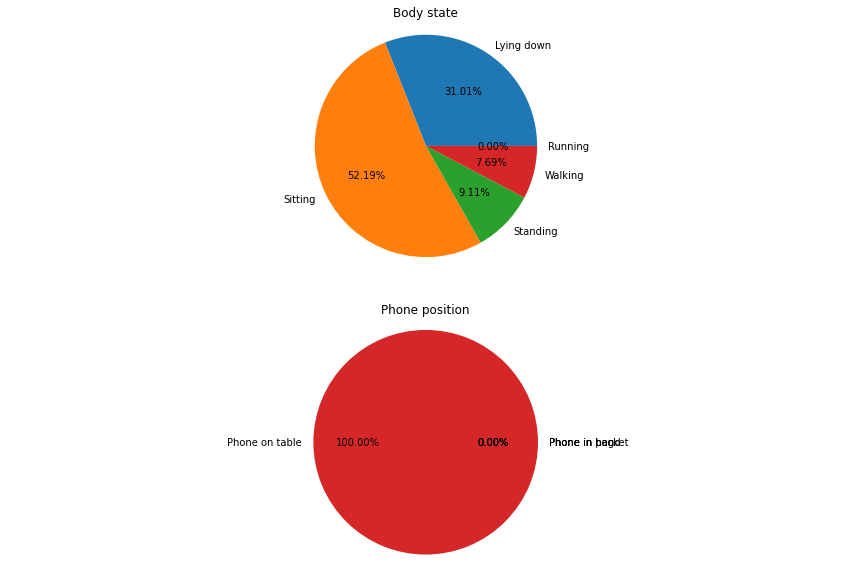

In [8]:
print("Since the collection of labels relied on self-reporting in-the-wild, the labeling may be incomplete.")
print("For instance, the users did not always report the position of their phones.")
fig = plt.figure(figsize = (15, 10), facecolor='white')

ax1 = plt.subplot(2, 1, 1)
labels_to_display = ['LYING_DOWN','SITTING','OR_standing','FIX_walking','FIX_running']
figure_pie_chart(Y,label_names,labels_to_display,'Body state',ax1)

ax2 = plt.subplot(2, 1, 2)
labels_to_display = ['PHONE_IN_HAND','PHONE_IN_BAG','PHONE_IN_POCKET','PHONE_ON_TABLE']
figure_pie_chart(Y,label_names,labels_to_display,'Phone position',ax2)

In [9]:
import datetime
import pytz

def get_actual_date_labels(tick_seconds):
    
    # Assuming the data comes from PST time zone
    time_zone = pytz.timezone('US/Pacific') 
    weekday_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    datetime_labels = []
    
    # Create datetime labels: weekday + time
    for timestamp in tick_seconds:
        tick_datetime = datetime.datetime.fromtimestamp(timestamp, tz=time_zone)
        weekday_str = weekday_names[tick_datetime.weekday()]
        time_of_day = tick_datetime.strftime('%I:%M%p')
        datetime_labels.append('%s\n%s' % (weekday_str, time_of_day))
        pass
    
    return datetime_labels
    
def figure__context_over_participation_time(timestamps,Y,label_names,labels_to_display,label_colors,use_actual_dates=False):

    fig = plt.figure(figsize=(10,7),facecolor='white')
    ax = plt.subplot(1,1,1)
    
    seconds_in_day = (60*60*24)

    ylabels = [];
    ax.plot(timestamps,len(ylabels)*np.ones(len(timestamps)),'|',color='0.5',label='(Collected data)')
    ylabels.append('(Collected data)')

    for (li,label) in enumerate(labels_to_display):
        lind = label_names.index(label)
        is_label_on = Y[:,lind]
        label_times = timestamps[is_label_on]

        label_str = get_label_pretty_name(label)
        ax.plot(label_times,len(ylabels)*np.ones(len(label_times)),'|',color=label_colors[li],label=label_str)
        ylabels.append(label_str)
        pass

    tick_seconds = range(timestamps[0],timestamps[-1],seconds_in_day)
    if use_actual_dates:
        tick_labels = get_actual_date_labels(tick_seconds)
        plt.xlabel('Time in San Diego',fontsize=14)
        pass
    else:
        tick_labels = (np.array(tick_seconds - timestamps[0]).astype(float) / float(seconds_in_day)).astype(int)
        plt.xlabel('days of participation',fontsize=14)
        pass
    
    ax.set_xticks(tick_seconds)
    ax.set_xticklabels(tick_labels,fontsize=14)

    ax.set_yticks(range(len(ylabels)))
    ax.set_yticklabels(ylabels,fontsize=14)

    ax.set_ylim([-1,len(ylabels)])
    ax.set_xlim([min(timestamps),max(timestamps)])
    
    return

Here is a track of when the user was engaged in different contexts. The bottom row (gray) states when sensors were recorded (the data-collection app was not running all the time). The context-labels annotations were self-reported by ther user (and then cleaned by the researchers).


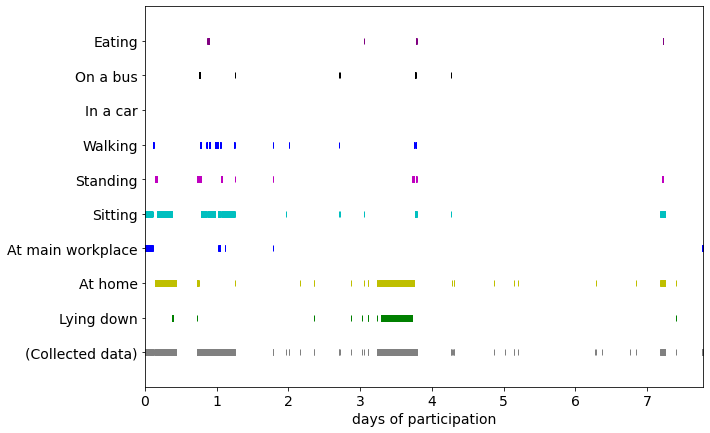

In [10]:
print("Here is a track of when the user was engaged in different contexts.",
      "The bottom row (gray) states when sensors were recorded (the data-collection app was not running all the time).",
      "The context-labels annotations were self-reported by ther user (and then cleaned by the researchers).")

labels_to_display = ['LYING_DOWN','LOC_home','LOC_main_workplace','SITTING','OR_standing','FIX_walking',\
                     'IN_A_CAR','ON_A_BUS','EATING']
label_colors = ['g','y','b','c','m','b','r','k','purple']
figure__context_over_participation_time(timestamps,Y,label_names,labels_to_display,label_colors)

### Sensor features:

The features are less intuitive to interpret than the labels.
They were calculated from the fuller raw-measurements from the various sensors on the smartphone or smartwatch.

We can start by looking at the feature names, where the prefix of each feature indicates the sensor where it came from.

For convenience, we add a function to parse the feature names and provide the code-name of the sensor they belong to. We'll use the code-names as they appear in the original ExtraSensory paper:  
**Acc** (phone-accelerometer), **Gyro** (phone-gyroscope), **WAcc** (watch-accelerometer), **Loc** (location), **Aud** (audio), and **PS** (phone-state).
Plus, the other sensors provided here that were not analyzed in the original paper: **Magnet** (phone-magnetometer), **Compass** (watch-compass), **AP** (audio properties, about the overall power of the audio), and **LF** (various low-frequency sensors).

In [11]:
def get_sensor_names_from_features(feature_names):
    feat_sensor_names = np.array([None for feat in feature_names]);
    for (fi,feat) in enumerate(feature_names):
        if feat.startswith('raw_acc'):
            feat_sensor_names[fi] = 'Acc';
            pass;
        elif feat.startswith('proc_gyro'):
            feat_sensor_names[fi] = 'Gyro';
            pass;
        elif feat.startswith('raw_magnet'):
            feat_sensor_names[fi] = 'Magnet';
            pass;
        elif feat.startswith('watch_acceleration'):
            feat_sensor_names[fi] = 'WAcc';
            pass;
        elif feat.startswith('watch_heading'):
            feat_sensor_names[fi] = 'Compass';
            pass;
        elif feat.startswith('location'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('location_quick_features'):
            feat_sensor_names[fi] = 'Loc';
            pass;
        elif feat.startswith('audio_naive'):
            feat_sensor_names[fi] = 'Aud';
            pass;
        elif feat.startswith('audio_properties'):
            feat_sensor_names[fi] = 'AP';
            pass;
        elif feat.startswith('discrete'):
            feat_sensor_names[fi] = 'PS';
            pass;
        elif feat.startswith('lf_measurements'):
            feat_sensor_names[fi] = 'LF';
            pass;
        else:
            raise ValueError("!!! Unsupported feature name: %s" % feat);

        pass;

    return feat_sensor_names; 

In [12]:
feat_sensor_names = get_sensor_names_from_features(feature_names);

for (fi,feature) in enumerate(feature_names):
    print("%3d) %s %s" % (fi,feat_sensor_names[fi].ljust(10),feature));
    pass;

  0) Acc        raw_acc:magnitude_stats:mean
  1) Acc        raw_acc:magnitude_stats:std
  2) Acc        raw_acc:magnitude_stats:moment3
  3) Acc        raw_acc:magnitude_stats:moment4
  4) Acc        raw_acc:magnitude_stats:percentile25
  5) Acc        raw_acc:magnitude_stats:percentile50
  6) Acc        raw_acc:magnitude_stats:percentile75
  7) Acc        raw_acc:magnitude_stats:value_entropy
  8) Acc        raw_acc:magnitude_stats:time_entropy
  9) Acc        raw_acc:magnitude_spectrum:log_energy_band0
 10) Acc        raw_acc:magnitude_spectrum:log_energy_band1
 11) Acc        raw_acc:magnitude_spectrum:log_energy_band2
 12) Acc        raw_acc:magnitude_spectrum:log_energy_band3
 13) Acc        raw_acc:magnitude_spectrum:log_energy_band4
 14) Acc        raw_acc:magnitude_spectrum:spectral_entropy
 15) Acc        raw_acc:magnitude_autocorrelation:period
 16) Acc        raw_acc:magnitude_autocorrelation:normalized_ac
 17) Acc        raw_acc:3d:mean_x
 18) Acc        raw_acc:3d:mean_y


In [13]:
def figure__feature_track_and_hist(X,feature_names,timestamps,feature_inds):
    seconds_in_day = (60*60*24);
    days_since_participation = (timestamps - timestamps[0]) / float(seconds_in_day);
    
    for ind in feature_inds:
        feature = feature_names[ind];
        feat_values = X[:,ind];
        
        fig = plt.figure(figsize=(10,3),facecolor='white');
        
        ax1 = plt.subplot(1,2,1);
        ax1.plot(days_since_participation,feat_values,'.-',markersize=3,linewidth=0.1);
        plt.xlabel('days of participation');
        plt.ylabel('feature value');
        plt.title('%d) %s\nfunction of time' % (ind,feature));
        
        ax1 = plt.subplot(1,2,2);
        existing_feature = np.logical_not(np.isnan(feat_values));
        ax1.hist(feat_values[existing_feature],bins=30);
        plt.xlabel('feature value');
        plt.ylabel('count');
        plt.title('%d) %s\nhistogram' % (ind,feature));
        
        pass;
    
    return;

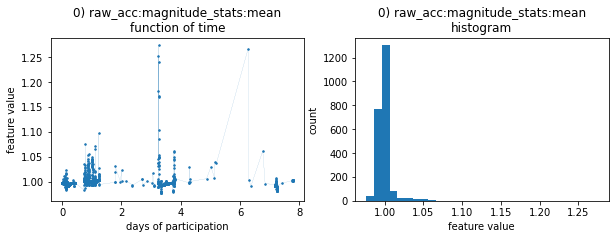

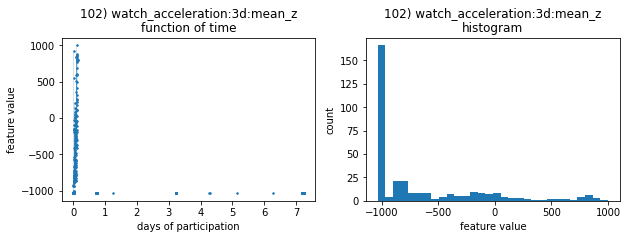

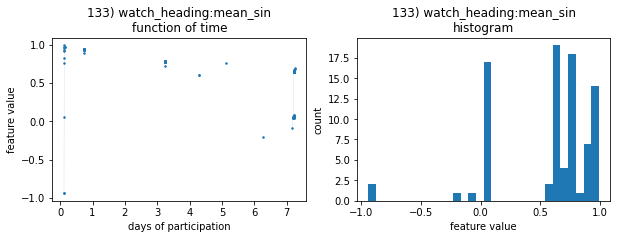

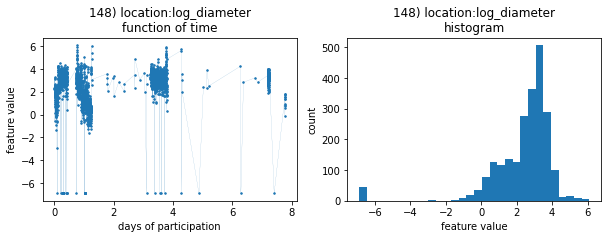

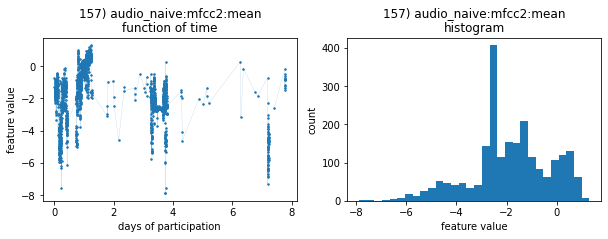

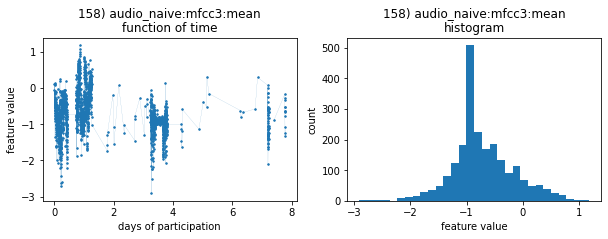

In [14]:
feature_inds = [0,102,133,148,157,158];
figure__feature_track_and_hist(X,feature_names,timestamps,feature_inds);

### Quick Test
Wrote a quick pipeline here in selecting the features manually and train on the target label.   
**Features selected**: Acc sensor and WAcc sensor  
**Target selected**: FIX_WALKING  
**Test set**: use last 5 user's data as test set

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

class select_features_by_sensors(BaseEstimator, TransformerMixin):
    
    def __init__(self, sensors_to_use, feature_names):
        self.sensors_to_use = sensors_to_use
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        fi = []
        for i, feature in enumerate(self.feature_names):
            if sensor_name_abbriviation[feature.split(':')[0]] in self.sensors_to_use:
                fi.append(i)
    
        return X[:, fi]
    
def select_target_label(y, target_label, label_names):
    for i, label_name in enumerate(label_names):
        if target_label == label_name:
            break
    return y[:, i]

def split_by_users(X, y, test_uuid, user_index):
    X_train, y_train = [], []
    X_test, y_test = [], []

    for i in range(60):
        if i in test_uuid:
            X_test.append(X[user_index[i]:user_index[i+1], :])
            y_test.append(y[user_index[i]:user_index[i+1]])
        else:
            X_train.append(X[user_index[i]:user_index[i+1], :])
            y_train.append(y[user_index[i]:user_index[i+1]])
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test)
    
    return X_train, y_train, X_test, y_test

In [19]:
from sklearn.pipeline import Pipeline
parameters = {
    'sensors_to_use': ['Acc','WAcc'],
    'target_label': 'FIX_WALKING',
    'test_uuid': list(range(56, 61)),
    'Imputation_strategy': 'mean'
}

pipe_line = Pipeline([
    ('feature_selector', select_features_by_sensors(parameters['sensors_to_use'], feature_names)),
    ('imputer', SimpleImputer(strategy=parameters['Imputation_strategy'])),
    ('std_scaler', StandardScaler())
])

sensor_name_abbriviation = {
    'raw_acc': 'Acc',
    'proc_gyro': 'Gyro', 
    'raw_magnet': 'Magnet',
    'watch_acceleration': 'WAcc',
    'watch_heading': 'Compass',
    'location': 'Loc',
    'location_quick_features': 'Loc',
    'audio_naive': 'Aud',
    'audio_properties': 'AP',
    'discrete': 'PS', 
    'lf_measurements': 'LF'
}

In [20]:
def load_all_data(uuid_list):
    X, y = [], []
    user_index = [0]
    for i, uuid in enumerate(uuid_list):
        X_i,y_i,M,timestamps,feature_names,label_names = read_user_data(uuid)
        user_index.append(user_index[i]+X_i.shape[0])
        X.append(X_i)
        y.append(y_i)
        
    X = np.concatenate(X)
    y = np.concatenate(y)

    return X, y, user_index, feature_names, label_names

In [21]:
X, y, user_index, feature_names, lable_names = load_all_data(uuid_list)

In [22]:
y_new = select_target_label(y, parameters['target_label'], label_names)
X_new = pipe_line.fit_transform(X, y_new)

In [23]:
X_new.shape, y_new.shape

((377346, 72), (377346,))

In [24]:
X_train, y_train, X_test, y_test = split_by_users(X_new, y_new, parameters['test_uuid'], user_index)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((363136, 72), (14210, 72), (363136,), (14210,))

A quick trial using logistic regression model and random forest model

In [26]:
import sklearn.linear_model as linear_model
import sklearn.ensemble as ensemble

lr_clf = linear_model.LogisticRegression(class_weight='balanced')
lr_clf.fit(X_train, y_train)
rf_clf = ensemble.RandomForestClassifier(class_weight='balanced')
rf_clf.fit(X_train, y_train)

D:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(class_weight='balanced')

In [27]:
type(lr_clf)

sklearn.linear_model._logistic.LogisticRegression

In [28]:
print('Logistic Regression: accuracy on training data %f' %lr_clf.score(X_train, y_train))
print('Logistic Regression: accuracy on test data %f' %lr_clf.score(X_test, y_test))
print('Random Forest: accuracy on training data %f' %rf_clf.score(X_train, y_train))
print('Random Forest: accuracy on test data %f' %rf_clf.score(X_test, y_test))

Logistic Regression: accuracy on training data 0.645887
Logistic Regression: accuracy on test data 0.627727
Random Forest: accuracy on training data 0.999986
Random Forest: accuracy on test data 0.944898


Choose Gyro and Loc features that are not so relavant

In [29]:
parameters = {
    'sensors_to_use': ['Gyro','Loc'],
    'target_label': 'FIX_WALKING',
    'test_uuid': list(range(56, 61)),
    'Imputation_strategy': 'mean'
}

pipe_line = Pipeline([
    ('feature_selector', select_features_by_sensors(parameters['sensors_to_use'], feature_names)),
    ('imputer', SimpleImputer(strategy=parameters['Imputation_strategy'])),
    ('std_scaler', StandardScaler())
])

In [30]:
y_new = select_target_label(y, parameters['target_label'], label_names)
X_new = pipe_line.fit_transform(X, y_new)
X_train, y_train, X_test, y_test = split_by_users(X_new, y_new, parameters['test_uuid'], user_index)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((363136, 43), (14210, 43), (363136,), (14210,))

In [32]:
lr_clf = linear_model.LogisticRegression(class_weight='balanced')
lr_clf.fit(X_train, y_train)
rf_clf = ensemble.RandomForestClassifier(class_weight='balanced')
rf_clf.fit(X_train, y_train)

D:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(class_weight='balanced')

In [33]:
print('The performance is worse than the Acc and WAcc sensors!')
print('Logistic Regression: accuracy on training data %f' %lr_clf.score(X_train, y_train))
print('Logistic Regression: accuracy on test data %f' %lr_clf.score(X_test, y_test))
print('Random Forest: accuracy on training data %f' %rf_clf.score(X_train, y_train))
print('Random Forest: accuracy on test data %f' %rf_clf.score(X_test, y_test))

The performance is worse than the Acc and WAcc sensors!
Logistic Regression: accuracy on training data 0.673566
Logistic Regression: accuracy on test data 0.587896
Random Forest: accuracy on training data 0.984642
Random Forest: accuracy on test data 0.934764


### Future Plans:
* Multi-class classifier: classify the body state   
* Feature selections: Using some feature seelction methods (eq. sequential forward selection and sequential backward selection) to select most relevant features.   
* Try different models and select the one that gives the best performance.  
* Build a simple nerual network, investigate the network structure and compare with the tranditional ML method.  